In this notebook we will be working on the [Kaggle project: SF Bay Area Bike Share](https://www.kaggle.com/benhamner/sf-bay-area-bike-share)

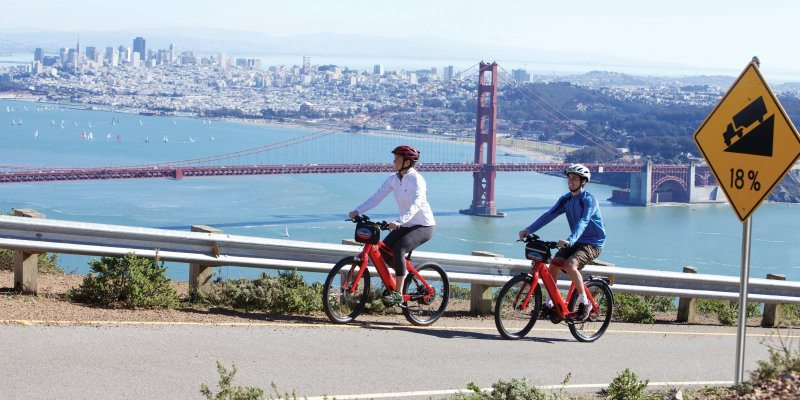


<a id='overview'></a>
### Project In a nutshell 


- We are trying to predict the **net change** in the bike stock (**bikes returned - bikes taken**)  at a specific station at a specific hour.

- We have 3 datasets: `station data`, `trip data`, `weather data`

 <!-- TEASER_END -->


# Table of contents

- [Project In a nutshell](#overview)
- ['Pen & Paper' thinking](#pen&paper)
- [Data exploration](#exploration)
    - [Missing values](#missing)
    - [Categorical features](#Categorical)
    - [Stations departures count](#departures)
    - [Moved stations on the map](#moved)
    - [Combine the stations](#stations)
    - [Duplicates](#dublicates)
    

- [Feature preprocessing](#feature)
    - [Add time features](#time)
    - [Add 'Duration' column](#duration)
    - [Outliers in duration](#outliers)
    

    
- [Monthly, daily, hourly trips charts](#charts)
    - [Monthly trips by subscription type in weekdays](#monthly)
    - [Monthly trips by subscription type in weekends](#weekends)
    - [Hourly trips by subscription type in weekdays](#hourlyweek)
    - [Hourly trips by subscription type in weekends](#hourly)
    - [Hourly trips by the day of  the week](#dayoweek)
    
    
- [Create hourly trip dataframe: hourly_trips](#hourlytrips)
    - [Encode the 'Month' column](#encode1)
    - [Flags for day groups](#flags)
    - [Encode the 'Day' column](#encodeday)
    - [Encode the 'Hour' column](#encodehour)
    - [Add 'Holiday' column](#holiday)
    - [Features dataset](#features)
    
    
- [Modeling approach](#modeling)
    - [Targets dataset](#targets)
    - [Data split with TimeSeriesSplit](#split)
    - [Features and targets datasets split](#featurestargets)
    - [Multi-target models](#multitarget)
    
    
- [Model with 140 stations](#140stations)   
    - [First baseline for the model with 140 stations](#baseline1)
    - ['get_val_score_rf' function](#valfunc)
    - [First scores of the model](#firstscore)
    - [Feature importance by Sklearn random forest](#featureimportance2)
    - [Feature importance by 'rfpimp'](#featureimportance)
    - [Hyperparameters tuning](#tuning)
    - [Grid Search CV](#grid)
    - [Hold-out set score](#holdout)
    - [Net rates dataframe](#netrate)
    - [RMSE of the 'predicted net changes' and the 'actual net changes'](#final)
 

- [Model with 70 stations](#70stations)
    - [Target datasets : y_train_net, y_test_net](#targetnet)
    - [First baseline method for net rate approach](#baselinenet)
    - [First model performance with net rate targets](#perform)
    - [Hold_out score](#final)


In [1]:
# Notebook setup
import pandas as pd
import numpy as np
import glob
from pandas.tseries.holiday import USFederalHolidayCalendar
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split


from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib

from rfpimp import *
from pprint import pprint

import folium

sns.set()

%matplotlib inline
# Set the option to display the max number of columns and rows 
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 20000)

<a id='pen&paper'></a>
### 'Pen & Paper' thinking
#### What can be the drivers of  the bike rentals in each station?
Bike rentals in each station can flactuate by two kind of reasons: 
1. Station specific factors which are more about the location and the environment of each station, like centrality, height difference etc
2. Dynamic factors affecting all the stations like weather and time.

Here are some main factors:

`Weather`: <br>
Since bike users are exposed directly to the weather conditions during the ride it is expected to be one of the main parameters.
- Snow
- Rain
- Ice etc

`Time`: <br>
Since we are working with data created by humans, it is intuitive to expect different characteristics in different time periods
- Month 
- Day of the week
- Holiday days
- Weekdays and weekends 
- Hour of the day

`Mobility in the city`: <br>
Since bikes are an option of transportation we need to take in to account the nature of the mobility (distribution of the mobility) in the city
- Centrality
- Population density of the area
- Residential or office(job) area
- Closeness to "hot" spots like parks, universities, culture and convention centers other easy public transportation availibilities
- Critical events' times (concert, a sport activity etc)

`Comparision with other transportation alternatives`: <br>
- Cost of other options
- Price of gas
- Time spend in the traffic jam
     
`Infrastructure`: <br>
 - Safe bike lanes
 - connections

<a id='exploration'></a>
# Data exploration
### Loading datasets & summaries
#### Station data

In [2]:
# Read the `station_data` 
station_df = pd.read_csv("station_data.csv")
station_df.head(2)

Id                               Name        Lat        Long  Dock Count  \
0   2  San Jose Diridon Caltrain Station  37.329732 -121.901782          27   
1   3              San Jose Civic Center  37.330698 -121.888979          15   

       City  
0  San Jose  
1  San Jose

In [3]:
# Summary of station_data
station_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 6 columns):
Id            76 non-null int64
Name          76 non-null object
Lat           76 non-null float64
Long          76 non-null float64
Dock Count    76 non-null int64
City          76 non-null object
dtypes: float64(2), int64(2), object(2)
memory usage: 3.6+ KB


#### Station locations on the map
To have an image of the stations let's see where the stations are on the map

#### Trip data

In [4]:
# Read the 'trip_data': trip_df
trip_df = pd.read_csv("trip_data.csv", 
                    parse_dates=['Start Date', 'End Date'], 
                    infer_datetime_format=True)

trip_df.head(2)

Trip ID          Start Date  Start Station            End Date  \
0   913460 2015-08-31 23:26:00             50 2015-08-31 23:39:00   
1   913459 2015-08-31 23:11:00             31 2015-08-31 23:28:00   

   End Station Subscriber Type  
0           70      Subscriber  
1           27      Subscriber

In [5]:
# Summary of trip_df
trip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354152 entries, 0 to 354151
Data columns (total 6 columns):
Trip ID            354152 non-null int64
Start Date         354152 non-null datetime64[ns]
Start Station      354152 non-null int64
End Date           354152 non-null datetime64[ns]
End Station        354152 non-null int64
Subscriber Type    354152 non-null object
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 16.2+ MB


There is an object type column: `Subscriber Type`. We need to encode this column's values to categories

#### Weather data
- The given weather dataset provides weather measurements with daily precision however we will make our analysis with samples that are in an hour range. 

- Even though the given dataset provides zip code specific weather data, during a day-time period the  measurement differences can be significant. So it would be better to have an hourly weather dataset.

- Therefore instead of using the given dataset, we will use the weather data taken from [Kaggle Datasets (Historical Hourly Weather Data 2012-2017)](https://www.kaggle.com/selfishgene/historical-hourly-weather-data) 

- Here, hourly weather measurements data of various weather attributes, such as temperature, humidity, air pressure, etc. are provided for many cities, including **San Francisco**,

- Additionally, for each city we also have the country, latitude and longitude information in a separate file.

#### Kaggle hourly weather dataset
- Since datasets are given by a common `datetime` column, we can read all the datasets and exctract the `"San Francisco"` columns in order to create a weather dataset related to our are of interest

In [6]:
# Pattern of weather attributes datasets: pattern
pattern = 'kaggle_data\*.csv'

# Save all matching files with glob function: weather_files
weather_files = glob.glob(pattern)

# Aggregate all the datasets in a list
# by subsetting the 'datetime' and 'San Francisco' column of each dataset
weather_df_lst = [pd.read_csv(file, usecols=["datetime", "San Francisco"]) for file in weather_files]

# Concat all the dataframes in the weather_df_lst
weather_df = pd.concat(weather_df_lst, axis=1)
print(weather_df.head(2))

# Set the first 'datetime' column as index and
# Drop the other 'datetime' columns
weather_df = weather_df.set_index(weather_df.iloc[:, 0]).drop("datetime", axis=1)

# Convert the index to datetime
weather_df.index=pd.to_datetime(weather_df.index)

# Set the column names 
column_names = ['Humidity', 'Pressure', 'Temperature', 'Weather Description', 'Wind Direction', 'Wind Speed']
weather_df.columns = column_names
weather_df

# Subset the date interval [2014-09-01: 2015-08-31] (interval of bike trip dates)
weather_df = weather_df["2014-09-01": "2015-08-31"]
weather_df.head(3)

              datetime  San Francisco             datetime  San Francisco  \
0  2012-10-01 12:00:00            NaN  2012-10-01 12:00:00            NaN   
1  2012-10-01 13:00:00           88.0  2012-10-01 13:00:00         1009.0   

              datetime  San Francisco             datetime  San Francisco  \
0  2012-10-01 12:00:00            NaN  2012-10-01 12:00:00            NaN   
1  2012-10-01 13:00:00         289.48  2012-10-01 13:00:00     light rain   

              datetime  San Francisco             datetime  San Francisco  
0  2012-10-01 12:00:00            NaN  2012-10-01 12:00:00            NaN  
1  2012-10-01 13:00:00          150.0  2012-10-01 13:00:00            2.0  


Humidity  Pressure  Temperature Weather Description  \
datetime                                                                   
2014-09-01 00:00:00      72.0    1024.0   293.995500        sky is clear   
2014-09-01 01:00:00      69.0    1024.0   294.414333        sky is clear   
2014-09-01 02:00:00      72.0    1024.0   293.579667        sky is clear   

                     Wind Direction  Wind Speed  
datetime                                         
2014-09-01 00:00:00           237.0         2.0  
2014-09-01 01:00:00           241.0         2.0  
2014-09-01 02:00:00           239.0         2.0

In [7]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2014-09-01 00:00:00 to 2015-08-31 23:00:00
Data columns (total 6 columns):
Humidity               8760 non-null float64
Pressure               8760 non-null float64
Temperature            8760 non-null float64
Weather Description    8760 non-null object
Wind Direction         8759 non-null float64
Wind Speed             8760 non-null float64
dtypes: float64(5), object(1)
memory usage: 479.1+ KB


- There is a missing value in `Wind Direction` column.
- `Weather Description` column is categorical. We need to convert the categories into dummy variables

In [8]:
# Summary statistics of station_df
weather_df.describe().T

count         mean        std         min       25%  \
Humidity        8760.0    86.355594  12.037149   26.000000    78.000   
Pressure        8760.0  1026.396119   8.010935  985.000000  1023.000   
Temperature     8760.0   288.063666   4.538506  276.145333   284.987   
Wind Direction  8759.0   208.150474  86.875425    0.000000   170.000   
Wind Speed      8760.0     2.476370   1.904894    0.000000     1.000   

                        50%          75%      max  
Humidity          88.000000    97.000000   100.00  
Pressure        1028.000000  1032.000000  1044.00  
Temperature      287.466917   290.150625   309.63  
Wind Direction   232.000000   270.000000   360.00  
Wind Speed         2.000000     3.000000    13.00

<a id='missing'></a>
### Missing values

In [9]:
# Look at the missing values in 3 datasets
print(station_df.isna().values.any())
print(trip_df.isna().values.any())
print(weather_df.isna().values.any())

False
False
True


In [10]:
# Impute the single missing value in weather data
weather_df["Wind Direction"].fillna(method='ffill', inplace=True)

Now we don't have expected missing values (the ones pandas can detect)

<a id='Categorical'></a>
### Categorical features
- Let's encode the categorical columns `Weather Description` and `Subscriber Type` in **weather_df**  and **trip_df** respectively with dummy variables.

- We will do the encoding for the categorical variables of the **trip_df** after doing some plotting

In [11]:
# Create dummy variables from 'Weather Description' column categories
dummies= pd.get_dummies(weather_df["Weather Description"], drop_first=True)
# Add the dummy variables to the weather_df and
# Drop the original features from the weather_df
weather_df= pd.concat([weather_df, dummies], axis=1).drop("Weather Description", axis=1)
weather_df.head(2)

Humidity  Pressure  Temperature  Wind Direction  \
datetime                                                               
2014-09-01 00:00:00      72.0    1024.0   293.995500           237.0   
2014-09-01 01:00:00      69.0    1024.0   294.414333           241.0   

                     Wind Speed  drizzle  few clouds  fog  haze  \
datetime                                                          
2014-09-01 00:00:00         2.0        0           0    0     0   
2014-09-01 01:00:00         2.0        0           0    0     0   

                     heavy intensity rain  light intensity drizzle  \
datetime                                                             
2014-09-01 00:00:00                     0                        0   
2014-09-01 01:00:00                     0                        0   

                     light intensity shower rain  light rain  mist  \
datetime                                                             
2014-09-01 00:00:00                            0           0     0   
2014-09-01 01:00:00                            0           0     0   

                     moderate rain  overcast clouds  proximity shower rain  \
datetime                                                                     
2014-09-01 00:00:00              0                0                      0   
2014-09-01 01:00:00              0                0                      0   

                     proximity thunderstorm  proximity thunderstorm with rain  \
datetime                                                                        
2014-09-01 00:00:00                       0                                 0   
2014-09-01 01:00:00                       0                                 0   

                     scattered clouds  shower rain  sky is clear  smoke  \
datetime                                                                  
2014-09-01 00:00:00                 0            0             1      0   
2014-09-01 01:00:00                 0            0             1      0   

                     thunderstorm  thunderstorm with heavy rain  \
datetime                                                          
2014-09-01 00:00:00             0                             0   
2014-09-01 01:00:00             0                             0   

                     thunderstorm with light rain  thunderstorm with rain  \
datetime                                                                    
2014-09-01 00:00:00                             0                       0   
2014-09-01 01:00:00                             0                       0   

                     very heavy rain  
datetime                              
2014-09-01 00:00:00                0  
2014-09-01 01:00:00                0

<a id='departures'></a>
#### Stations departures count
Let's count the departures from each stations

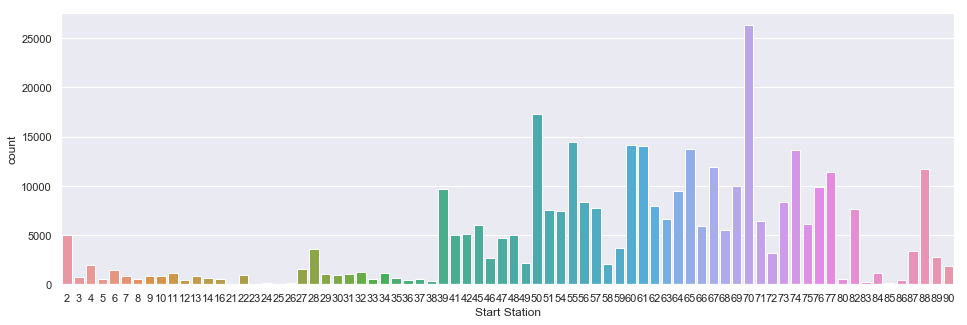

In [12]:
fig, ax=plt.subplots(figsize=(16, 5))
sns.countplot(trip_df["Start Station"], ax=ax);

We see that stations traffic is not balanced

<a id='moved'></a>
#### Moved stations on the map
- Let's see the moved stations on the map. 
- Please zoom in and hoover over the markers to see the position and the number of each moved stations.
- The blue circles represent the new locations.

In [13]:
## Moved stations
moved_stations = [23, 24, 49, 69, 72]
new_stations1 = [85, 86, 87, 88, 89]
new_stations2 = [90]

# Create station list
station_lst = station_df["Id"].tolist()
station_moved = station_df[station_df["Id"].isin(moved_stations)]
station_new1 = station_df[station_df["Id"].isin(new_stations1)]
station_new2 = station_df[station_df["Id"].isin(new_stations2)]

# Create the list of coordinates
coord_list1 = list(zip(station_moved["Lat"], station_moved["Long"]))
coord_list2 = list(zip(station_new1["Lat"], station_new1["Long"]))
coord_list3 = list(zip(station_new2["Lat"], station_new2["Long"]))

# Zip the coordinates and the stations ids
moved_coords1 = list(zip(coord_list1, moved_stations))
moved_coords2 = list(zip(coord_list2, new_stations1))
moved_coords3 = list(zip(coord_list3, new_stations2))

## See the moved stations
stations_map = folium.Map(location=[37.56236, -122.150876], 
                          tiles='cartodbpositron',
                          zoom_start=10) 

# Add the pointers to the map by iterating over the coordinates
for point, station in moved_coords1: #
            marker = folium.Marker(location=point, popup='<i>Mt. Hood Meadows</i>', tooltip=station)
            marker.add_to(stations_map)    
            
for point, station in moved_coords2:
    marker2= folium.CircleMarker(location=point, popup='<i>Mt. Hood Meadows</i>', tooltip=station, radius=7)
    marker2.add_to(stations_map)
    
for point, station in moved_coords3:
    marker3= folium.CircleMarker(location=point, popup='<i>Mt. Hood Meadows</i>', tooltip=station, radius=7)
    marker3.add_to(stations_map)

stations_map

<a id='stations'></a>
#### Combine the stations
- Generally stations moved to close points. Even though station 24 moved quite far away as station 86 for the we will combine all the stations

In [14]:
moved_stations=[23, 24, 49, 69, 72]
new_stations1=[85, 86, 87, 88, 89]
new_stations2=[90]

# Zip the moved stations and the new ones
replace_zip= list(zip(moved_stations, new_stations1))

# Replace the moved station values in 'Start Station' column with the new ones
for s1, s2 in replace_zip:
    trip_df.loc[trip_df["Start Station"]==s1, "Start Station"]=s2

# Replace the station 89 in 'Start Station' column with 90    
trip_df.loc[trip_df["Start Station"]==89, "Start Station"]=90

# Replace the moved station values in 'End Station' column with the new ones
for s1, s2 in replace_zip:
    trip_df.loc[trip_df["End Station"]==s1, "End Station"]=s2

# Replace the station 89 in 'End Station' column with 90         
trip_df.loc[trip_df["End Station"]==89, "End Station"]=90

#### Delete the moved stations from `station_df`
Since we converted the moved stations to new stations we should filter out the old stations from `station_df`.

In [15]:
# Drop the old stations
station_df= station_df[~station_df['Id'].isin(moved_stations + [89])]

<a id='dublicates'></a>
### Duplicates
Let's check the duplicates in 3 datasets

In [16]:
# Check the duplicates in 'station_df' values
print(station_df["Id"].nunique()==len(station_df["Id"]))

# Check the duplicates in 'Trip ID' values in trip_df
print(trip_df["Trip ID"].nunique()==len(trip_df["Trip ID"]))

# Check the duplicates in 'Date' values in weather_df
print(weather_df.index.nunique()==len(weather_df))

True
True
True


<a id='feature'></a>
## Feature preprocessing
<a id='time'></a>
#### Add time features
- Since the bike usage is very related with the breakdowns of the time we will add them as seperate features.
- Here we need to be aware of the **cyclic** nature of our time data and the non-linearity dependence between the bike rentals and the hours of the day.

Examples: 
- Regarding the seasonal effects we can expect that number of bike rentals in December is more similar to rentals in January, than rentals in May. However we represent December with the number 12, January with 1 and May with 5. Contrary to the reality, in the numeric represantation January is closer to May.


- Similarly we can expect the number of rentals in the 23th hour is closer the number in the 0th hour in the night than the number in the 8th hour in the morning. Even though there is only 1 hour difference between 0h-23h with numeric(0 and 23) represantation the difference is the largest

- This is not a good represantation for the linear models as the effect of time becomes monotonic i.e either the target will increase or decrease with time. 

- The models that take the distance into account will be misinformed.

- For decision trees, time values close to each other will be grouped together. So 23h will be in different group than 0h.

- We should create 24 different columns for hours and 12 different columns for month with binary (0,1) values
- Here are the new features:
    - Month(0-11)
    - Day (day of the week)
    - Hour(0-23)
    - Holiday (1 or 0)
    
- We can add this features to `trip_df` 

In [17]:
# Use the 'Start Date' column to create the time features
trip_df["Month"]= trip_df["Start Date"].dt.month
trip_df["Day"]= trip_df["Start Date"].dt.dayofweek
trip_df["Hour Start"]= trip_df["Start Date"].dt.hour

<a id='duration'></a>
#### Add 'Duration' column

In [18]:
# Create the trip duration column
trip_df["Duration"]= trip_df["End Date"]- trip_df["Start Date"]
# Convert the Duration into minutes
trip_df['Duration']=trip_df['Duration']/np.timedelta64(1,'m')

<a id='outliers'></a>
#### Outliers in `Duration` 
We will take out the trips longer than two hours.

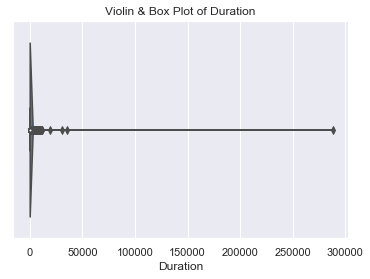

In [19]:
# Plot the boxplot
ax=sns.boxplot(x="Duration", data=trip_df, width=0.2, orient="h")

# Add the violinplot on the same figure
sns.violinplot(x="Duration", data=trip_df, bw=.2, orient="h")

# Add the label and title
ax.set(xlabel='Duration', title="Violin & Box Plot of Duration");

In [20]:
# Find the inter quantile of the duration
q1=trip_df['Duration'].quantile(0.25)
q3= trip_df['Duration'].quantile(0.75)
iqr = q3 - q1

print("Lower bound of outliers:", q1 - 1.5 * iqr)
print("Upper bound of outliers:", q3 + 1.5 * iqr, "\n")

# Only take the rows with duration is less then 120 min: trips
trips = trip_df[trip_df["Duration"] < 120]

# Print the percetage of removed data
print("The percentage of data removed:",\
      np.around((trip_df["Duration"] > 120).sum()/len(trip_df["Duration"])*100, decimals=2))

Lower bound of outliers: -3.0
Upper bound of outliers: 21.0 

The percentage of data removed: 1.53


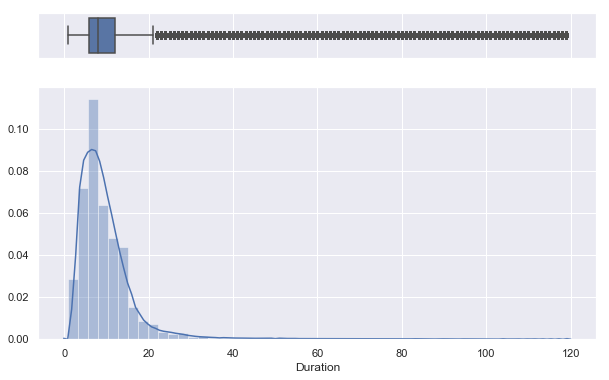

In [21]:
# Create a figure and two axes for boxplot and distplot
fig, (ax_box, ax_dist) = plt.subplots(nrows=2, 
                                      sharex=True, 
                                      figsize=(10, 6), 
                                      gridspec_kw={"height_ratios": (.15, .85)})
 
# Plot the boxplot on the ax_box axis
sns.boxplot(trips["Duration"], ax=ax_box)
# Plot the distplot on the ax_dist axis
sns.distplot(trips["Duration"], ax=ax_dist)
 # Remove xlabel for the boxplot
ax_box.set(xlabel='');

<a id='charts'></a>
### Monthly, daily, hourly trips charts 

Let's see the global (non station based) trip patterns by the breakdown of time. It is intiutive to expect to see meaningful relations on the charts.

Here are our steps:
- Observe the data by splitting it into **"weekdays"** and **"weekends"**.
- We will also start by the longer time frames and follow by the shorter time frames

In [22]:
# Create the 'weekdays' and 'weekends' dataframes
weekdays=trips[trips["Start Date"].dt.weekday <5]
weekends=trips[trips["Start Date"].dt.weekday >=5]

### A plot function for groups: `group_plot`
Let's define a plot function for plotting the dataframes groupped by different columns and different agregation functions

In [23]:
def group_plot(df, lst, agg_func, labelx, labely, title):
    '''
    Takes a dataframe, a list of columns to groupby, an aggregation function for the groups, 
    3 strings: label of x-axis, label of y-axis and title returns a line plot
    Plots the data with labels and title.
    '''
    plt.style.use('fivethirtyeight')
    group= getattr(df.groupby(lst), agg_func)().unstack(lst[1])/1000
    ax= group.plot(figsize=(11,4), rot=70, fontsize=11)        
    ax.set_xlabel(labelx)
    ax.set_ylabel(labely)
    ax.set_title(title)
    plt.show()

#### Monthly trips by subscription type in weekdays

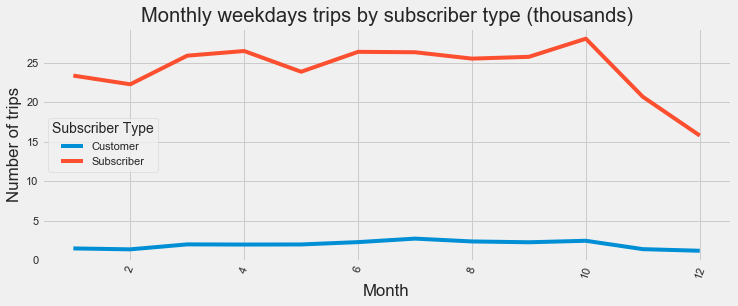

In [24]:
labelx= "Month"
labely="Number of trips"
title= "Monthly weekdays trips by subscriber type (thousands)"
group_plot(weekdays,["Month", "Subscriber Type"], 'size', labelx, labely, title)

- Number of subscriber type users are dominating during weekdays. Also number of subscribers' usage vary monthly. Especially after October till December decreasing steadily.

#### Monthly trips by subscription type in weekends

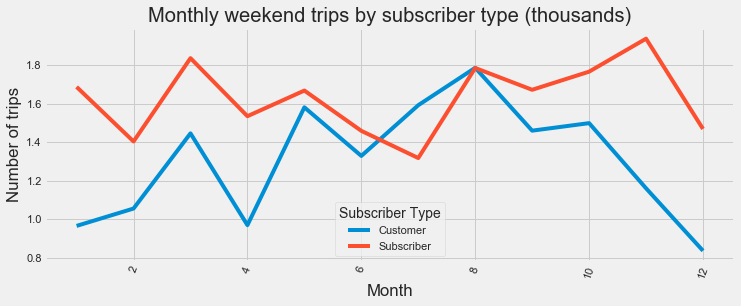

In [25]:
title= "Monthly weekend trips by subscriber type (thousands)"
group_plot(weekends,["Month", "Subscriber Type"], 'size', labelx, labely, title)

- From the chart we can see that total daily usage is less than weekdays. Also the relative usage between subscribers and the casual users are different. Number of casual users increased in weekends compare to weekdays. It might happen due to the visitors. 

#### Daily trips by subscription type in weekdays

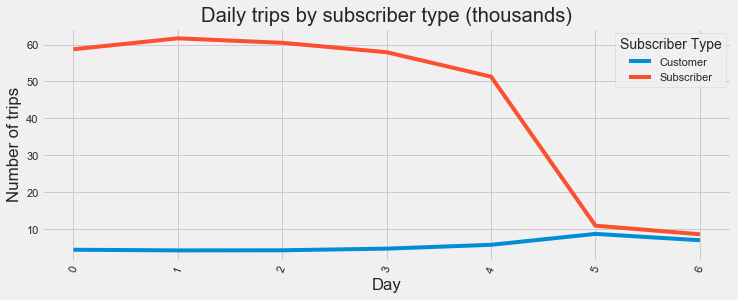

In [26]:
labelx= "Day"
title= "Daily trips by subscriber type (thousands)"
group_plot(trips,["Day", "Subscriber Type"], 'size', labelx, labely, title)

- Bike usage decrease on fridays compare to other weekdays. 

<a id='hourlyweek'></a>
#### Hourly trips by subscription type in weekdays

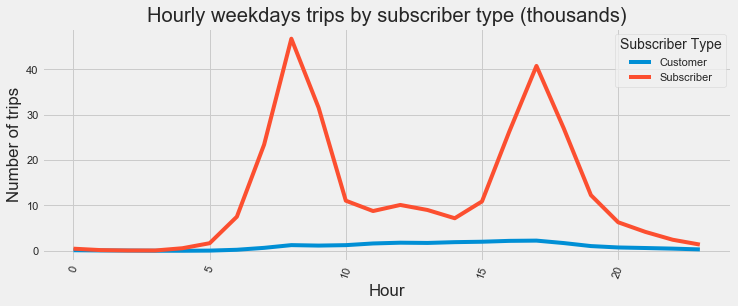

In [27]:
labelx= "Hour"
title= "Hourly weekdays trips by subscriber type (thousands)"
group_plot(weekdays,["Hour Start", "Subscriber Type"], 'size', labelx, labely, title)

- Firstly, bike usage between 0h-4h is close to zero.
- Subscriber usage is increasing after 5h and making first peak around 8h which is high probably due to commuting to work or schools.
- The second peak is around 17h which is high probably due to commuting back from work or schools
- It is intiutive that people who have a regular schedule prefer to subscribe to the system 
- However we will not use the **subscriber type** information in our model because when we want to predict future data of bike stock net change in the next hour at that moment we will not have the subscriber type data for the coming hour(s).

<a id='hourly'></a>
#### Hourly trips by subscription type in weekends

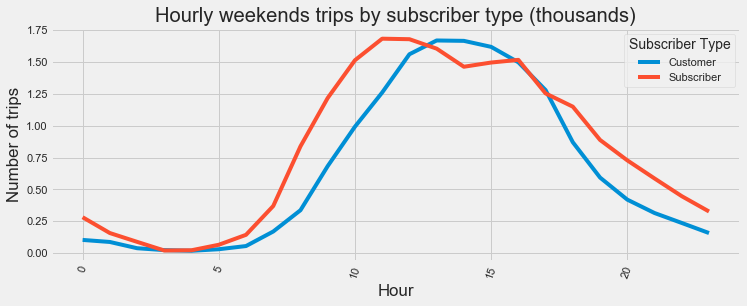

In [28]:
title= "Hourly weekends trips by subscriber type (thousands)"
group_plot(weekends,["Hour Start", "Subscriber Type"], 'size', labelx, labely, title)

<a id='dayoweek'></a>
#### Hourly trips by the day of  the week 
Let's create a dataframe with the columns showing the global count of bike trips started in each hour in order to use for the Seaborn's poinplot function.

In [29]:
# Group the trips based on 'Hour Start' and 'Day'
# Aggregate by size of the groups
hourly=trips.groupby(["Hour Start", "Day"]).size().reset_index("Day").reset_index()
# Change the name of the columns
hourly.columns=["Hour Start", "Day", "Total"]
hourly.head(2)

Hour Start  Day  Total
0           0    0     87
1           0    1    117

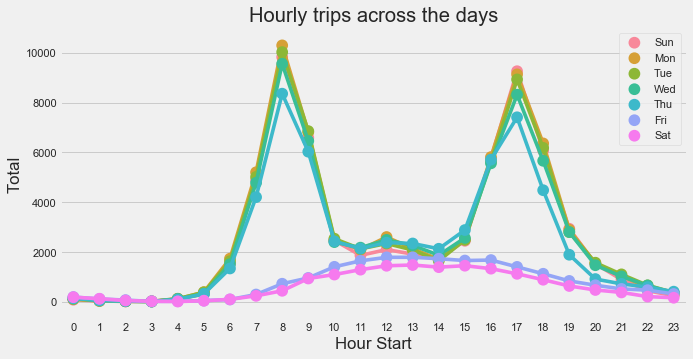

In [30]:
# Plot the hourly rental means in the weekdays and weekends on poinplot
fig, ax=plt.subplots(figsize=(10, 5))

sns.pointplot(x="Hour Start", 
              y="Total", 
              hue="Day", 
              data=hourly, 
              errwidth=0,
              scale=.5, 
              ax=ax);

hue_labels = ["Sun", "Mon","Tue","Wed","Thu","Fri", "Sat"]
leg_handles = ax.get_legend_handles_labels()[0]
ax.legend(leg_handles, hue_labels);

ax.set_title("Hourly trips across the days");

We can see the difference in the bike usage hours patterns of the weekdays and weekends

<a id='hourlytrips'></a>
### Create hourly trip dataframe: `hourly_trips`
After getting some insights through the charts now we can start creating our hourly features dataframe.
- We have two datasets to create our features: hourly weather data set `weather_df` and trips dataset `trips_df`
- Weather data is already hourly sampled so we will also resample the trips data hourly by counting the **number of departures** from a station and the **number of arrivals** to a station.

- We will later merge the hourly weather data and hourly trips data.


- To create `hourly_trips` dataframe, instead of indidividual informations of bike trips like start station, end station etc we will only use hourly counts of bike trips and the time features like the month of the year, day of the week, hour of the day etc

- We start by resampling the `trip_df` by hour and taking the size of each sample(number of bike trips in each hour)

In [31]:
# Resample trips_df by hour and get the size of each hour samples
hourly_total=trip_df.set_index("Start Date").resample("H").size()
# Create hourly_trips dataframe 
hourly_trips=hourly_total.to_frame(name="Total")
# Change the index name
hourly_trips.index.rename('Date', inplace=True)

# Lets add again time variables 
# Use the index to create the time features
hourly_trips["Month"]= hourly_trips.index.month
hourly_trips["Day"]= hourly_trips.index.dayofweek
hourly_trips["Hour"]= hourly_trips.index.hour

# Drop the 'Total' column
hourly_trips.drop("Total", axis=1, inplace=True)

<a id='encode1'></a>
#### Encode the `Month` column
- Represent the months with binary encoding in seperate columns like m0, m1,..m12

In [32]:
# Add month dummy variables: m0, m1,..m12
dummy_months = pd.get_dummies(hourly_trips["Month"], drop_first=True)

# Add the dummy variables to the hourly_trips and
# Drop the original features from the hourly_trips
hourly_trips = pd.concat([hourly_trips, dummy_months], axis=1).drop("Month", axis=1)
# Rename the month columns
hourly_trips.columns = ["m"+ str(col) if type(col)==int else col for col in hourly_trips.columns]
hourly_trips.head(2)

Day  Hour  m2  m3  m4  m5  m6  m7  m8  m9  m10  m11  m12
Date                                                                         
2014-09-01 00:00:00    0     0   0   0   0   0   0   0   0   1    0    0    0
2014-09-01 01:00:00    0     1   0   0   0   0   0   0   0   1    0    0    0

<a id='flags'></a>
#### Flags for day groups
Based on the daily number of trips, we can also group the data into 3 as
- `"WD1"`: weekdays 1, group of (Monday, Tuesday, Wednesday)
- `"WD2"`: weekdays 2, group of (Thursday, Friday)
- `"WKD"`: weekends

In [33]:
# Boolean dictionary to map the 'True' values into 1 and "False" values into 0
bool_dct = {True:1, False:0}
# Only two flags would be enough to represent 3 partitions of the days
# hourly_trips["WD1"]=hourly_trips["Day"].isin([0,1,2]).map(bool_dct)
hourly_trips["WD2"] = hourly_trips["Day"].isin([3,4]).map(bool_dct)
hourly_trips["WKD"] = hourly_trips["Day"].isin([5,6]).map(bool_dct)
hourly_trips.head(2)

Day  Hour  m2  m3  m4  m5  m6  m7  m8  m9  m10  m11  m12  \
Date                                                                            
2014-09-01 00:00:00    0     0   0   0   0   0   0   0   0   1    0    0    0   
2014-09-01 01:00:00    0     1   0   0   0   0   0   0   0   1    0    0    0   

                     WD2  WKD  
Date                           
2014-09-01 00:00:00    0    0  
2014-09-01 01:00:00    0    0

<a id='encodeday'></a>
#### Encode the `Day` column
- Represent the days with binary encoding in seperate columns like d0, d1,..d6

In [34]:
## Add day dummy variables: d0, d1,..d6
dummy_days = pd.get_dummies(hourly_trips["Day"], drop_first=True)

# Add the dummy variables to the hourly_trips and
# Drop the original features from the hourly_trips
hourly_trips= pd.concat([hourly_trips, dummy_days], axis=1).drop("Day", axis=1)
# Rename the day columns
hourly_trips.columns= ["d"+ str(col) if type(col)==int else col for col in hourly_trips.columns]
hourly_trips.head(2)

Hour  m2  m3  m4  m5  m6  m7  m8  m9  m10  m11  m12  WD2  \
Date                                                                            
2014-09-01 00:00:00     0   0   0   0   0   0   0   0   1    0    0    0    0   
2014-09-01 01:00:00     1   0   0   0   0   0   0   0   1    0    0    0    0   

                     WKD  d1  d2  d3  d4  d5  d6  
Date                                              
2014-09-01 00:00:00    0   0   0   0   0   0   0  
2014-09-01 01:00:00    0   0   0   0   0   0   0

<a id='encodehour'></a>
#### Encode the '`Hour`' column
- Represent the hours with binary encoding in seperate columns like h0, h1,..h23

In [35]:
## Add hour dummy variables: h0, h1,..h23
dummy_hours= pd.get_dummies(hourly_trips["Hour"], drop_first=True)

# Add the dummy variables to the hourly_trips and
# Drop the original features from the hourly_trips
hourly_trips= pd.concat([hourly_trips, dummy_hours], axis=1).drop("Hour", axis=1)
# Rename the hour columns
hourly_trips.columns= ["h"+str(col) if type(col)==int else col for col in hourly_trips.columns]
hourly_trips.head(2)

m2  m3  m4  m5  m6  m7  m8  m9  m10  m11  m12  WD2  WKD  \
Date                                                                           
2014-09-01 00:00:00   0   0   0   0   0   0   0   1    0    0    0    0    0   
2014-09-01 01:00:00   0   0   0   0   0   0   0   1    0    0    0    0    0   

                     d1  d2  d3  d4  d5  d6  h1  h2  h3  h4  h5  h6  h7  h8  \
Date                                                                          
2014-09-01 00:00:00   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2014-09-01 01:00:00   0   0   0   0   0   0   1   0   0   0   0   0   0   0   

                     h9  h10  h11  h12  h13  h14  h15  h16  h17  h18  h19  \
Date                                                                        
2014-09-01 00:00:00   0    0    0    0    0    0    0    0    0    0    0   
2014-09-01 01:00:00   0    0    0    0    0    0    0    0    0    0    0   

                     h20  h21  h22  h23  
Date                                     
2014-09-01 00:00:00    0    0    0    0  
2014-09-01 01:00:00    0    0    0    0

<a id='holiday'></a>
#### Add holiday column
We might also expect the users behave differently on holidays. So it can be a good idea to add an holiday indicator.

In [36]:
# Use pandas US calendar
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=hourly_trips.index.min(), end=hourly_trips.index.max())
# Convert the calendar index into array
holidays = pd.to_datetime(holidays, format='%Y/%m/%d').date
# Create 'Holiday' column with binary values
hourly_trips["Holiday"]=[1 if day==True else 0 for day in hourly_trips.index.isin(holidays)]
hourly_trips.head(2)

m2  m3  m4  m5  m6  m7  m8  m9  m10  m11  m12  WD2  WKD  \
Date                                                                           
2014-09-01 00:00:00   0   0   0   0   0   0   0   1    0    0    0    0    0   
2014-09-01 01:00:00   0   0   0   0   0   0   0   1    0    0    0    0    0   

                     d1  d2  d3  d4  d5  d6  h1  h2  h3  h4  h5  h6  h7  h8  \
Date                                                                          
2014-09-01 00:00:00   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2014-09-01 01:00:00   0   0   0   0   0   0   1   0   0   0   0   0   0   0   

                     h9  h10  h11  h12  h13  h14  h15  h16  h17  h18  h19  \
Date                                                                        
2014-09-01 00:00:00   0    0    0    0    0    0    0    0    0    0    0   
2014-09-01 01:00:00   0    0    0    0    0    0    0    0    0    0    0   

                     h20  h21  h22  h23  Holiday  
Date                                              
2014-09-01 00:00:00    0    0    0    0        1  
2014-09-01 01:00:00    0    0    0    0        0

<a id='features'></a>
### Features dataset
- As we mentioned before hourly trip data and the weather data will be our features data
- Let's now merge the `hourly_trips` and `weather_df` to create the features dataset

In [37]:
features_df = pd.concat([hourly_trips, weather_df], axis=1).reset_index(drop=True)
features_df.head(2)

m2  m3  m4  m5  m6  m7  m8  m9  m10  m11  m12  WD2  WKD  d1  d2  d3  d4  \
0   0   0   0   0   0   0   0   1    0    0    0    0    0   0   0   0   0   
1   0   0   0   0   0   0   0   1    0    0    0    0    0   0   0   0   0   

   d5  d6  h1  h2  h3  h4  h5  h6  h7  h8  h9  h10  h11  h12  h13  h14  h15  \
0   0   0   0   0   0   0   0   0   0   0   0    0    0    0    0    0    0   
1   0   0   1   0   0   0   0   0   0   0   0    0    0    0    0    0    0   

   h16  h17  h18  h19  h20  h21  h22  h23  Holiday  Humidity  Pressure  \
0    0    0    0    0    0    0    0    0        1      72.0    1024.0   
1    0    0    0    0    0    0    0    0        0      69.0    1024.0   

   Temperature  Wind Direction  Wind Speed  drizzle  few clouds  fog  haze  \
0   293.995500           237.0         2.0        0           0    0     0   
1   294.414333           241.0         2.0        0           0    0     0   

   heavy intensity rain  light intensity drizzle  light intensity shower rain  \
0                     0                        0                            0   
1                     0                        0                            0   

   light rain  mist  moderate rain  overcast clouds  proximity shower rain  \
0           0     0              0                0                      0   
1           0     0              0                0                      0   

   proximity thunderstorm  proximity thunderstorm with rain  scattered clouds  \
0                       0                                 0                 0   
1                       0                                 0                 0   

   shower rain  sky is clear  smoke  thunderstorm  \
0            0             1      0             0   
1            0             1      0             0   

   thunderstorm with heavy rain  thunderstorm with light rain  \
0                             0                             0   
1                             0                             0   

   thunderstorm with rain  very heavy rain  
0                       0                0  
1                       0                0

Finally, we have our features dataset: `features_df`  

In [38]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 71 columns):
m2                                  8760 non-null uint8
m3                                  8760 non-null uint8
m4                                  8760 non-null uint8
m5                                  8760 non-null uint8
m6                                  8760 non-null uint8
m7                                  8760 non-null uint8
m8                                  8760 non-null uint8
m9                                  8760 non-null uint8
m10                                 8760 non-null uint8
m11                                 8760 non-null uint8
m12                                 8760 non-null uint8
WD2                                 8760 non-null int64
WKD                                 8760 non-null int64
d1                                  8760 non-null uint8
d2                                  8760 non-null uint8
d3                                  8760 non-null uin

<a id='modeling'></a>
# Modeling approach

- We will try to predict the hourly net change in the bike stock in each station.
- We created our features set with time and weather attributes.
- Feature dataset has the shape `[n_hours, n_time&weather_attributes]`


- Here the question is *"how should we represent the targets dataset?"*
- We can try two options:
    - 1) a matrix of **hours** and **stations net changes** (*trips ends in a station - trips starts in a station*)
    - 2) a matrix of **hours** and **arrivals** and **departures** for each stations separetely
    
    
    
- In the first option the shape will be `[n_hours, n_stations]`, in the second option the shape will be `[n_hours, 2*n_stations]`

- Since arrivals and departures are independent from each other we can represent them separetely.


- At first sight each option has it is own advantages and disadvantages:
    - First one is less complicated. In our case targets will have only 70 columns.
    - Also this(net change) is the direct goal asked in the question.
    - However taking the arrival and departure differences offsets the additional information related to each station. 
    - For instance, let's think of two cases: a combination of the stations in a quite hour with no traffic and a combination of stations with intense but balanced(arrivals equal to departures) traffic.
    - In both cases targets will be the same. Here the difference is not discriminative. 
    - In separete version it reveals the information about entire traffic. It makes the targets space more sparse.
    - On the other hand it is more complicated, it doubles the targets dimensions. In our case there will be 140 columns. Maybe it might affect severely the performance of the model. 
    - Since in this case we just care the net change using denser target space might be better.


- Though we will try the both options to see the results

- We start modeling by with the targets in which the arrivals and departures are separeted.

<a id='targets'></a>
### Targets dataset with 140 columns

- Targets dataset will have the shape `[n_hours, 2*n_stations]` in our example `[8760, 140]`

- For each **hour** row, there will be columns with the **count of departures** from each station and the **count of arrivals** to each station

Here are the steps to create the targets dataframe:
- We will extract the station ids from `station_df` and
- create station arrival and  station departures columns  by iterating over `trips_df`

#### Arrivals and departures hourly count

In [39]:
# Create a list containing station ids
station_lst=station_df["Id"].tolist()

# Create departure columns' names
# 'd' stands for departures
departure_lst=[str(station) + "d" for station in station_lst]
# Create arrival columns' names
# 'a' stands for arrivals
arrival_lst=[str(station)+ "a" for station in station_lst]

# Create arrival and departure dictionaries
arrival_dict=dict(zip(station_lst, arrival_lst))
departure_dict=dict(zip(station_lst, departure_lst))

# Create targets dataframe: station_matrix
station_matrix=pd.DataFrame(columns=arrival_lst + departure_lst)

# Concat the trips_df and station_matrix: trips_extended
trips_extended=pd.concat([trip_df, station_matrix], sort=False).reset_index()

# Iterate over the trips_extended df and 
# assign 1 to the arrival column of the corresponding the Start Station on the same the row
# if on a row the 'Start Station' is 50 then the 50_a column value of the same row will be 1
# The same procedure is applied for the departure columns also ie
# if on a row the 'End Station' is 70 then the '70_d' column value of the same row will be 1
for i in trips_extended.index:
    trips_extended.at[i, arrival_dict[trips_extended.at[i,"Start Station"]]]=1
    trips_extended.at[i, departure_dict[trips_extended.at[i,"End Station"]]]=1

# After assigning the 1 value for each station's relevant arrival and departure columns
# fill the other NaN values with 0
trips_extended= trips_extended.fillna(0)
trips_extended.head(2)

index   Trip ID          Start Date  Start Station            End Date  \
0      0  913460.0 2015-08-31 23:26:00           50.0 2015-08-31 23:39:00   
1      1  913459.0 2015-08-31 23:11:00           31.0 2015-08-31 23:28:00   

   End Station Subscriber Type  Month  Day  Hour Start  Duration  2a  3a  4a  \
0         70.0      Subscriber    8.0  0.0        23.0      13.0   0   0   0   
1         27.0      Subscriber    8.0  0.0        23.0      17.0   0   0   0   

   5a  6a  7a  8a  9a  10a  11a  12a  13a  14a  16a  21a  22a  85a  25a  86a  \
0   0   0   0   0   0    0    0    0    0    0    0    0    0    0    0    0   
1   0   0   0   0   0    0    0    0    0    0    0    0    0    0    0    0   

   26a  27a  28a  29a  30a  31a  32a  33a  34a  35a  36a  37a  38a  41a  42a  \
0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1    0    0    0    0    0    1    0    0    0    0    0    0    0    0    0   

   45a  46a  47a  48a  87a  50a  51a  39a  54a  55a  56a  57a  58a  59a  60a  \
0    0    0    0    0    0    1    0    0    0    0    0    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

   61a  62a  63a  64a  65a  66a  67a  68a  88a  70a  71a  90a  73a  74a  75a  \
0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

   76a  77a  80a  82a  83a  84a  2d  3d  4d  5d  6d  7d  8d  9d  10d  11d  \
0    0    0    0    0    0    0   0   0   0   0   0   0   0   0    0    0   
1    0    0    0    0    0    0   0   0   0   0   0   0   0   0    0    0   

   12d  13d  14d  16d  21d  22d  85d  25d  86d  26d  27d  28d  29d  30d  31d  \
0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0    1    0    0    0    0   

   32d  33d  34d  35d  36d  37d  38d  41d  42d  45d  46d  47d  48d  87d  50d  \
0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

   51d  39d  54d  55d  56d  57d  58d  59d  60d  61d  62d  63d  64d  65d  66d  \
0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

   67d  68d  88d  70d  71d  90d  73d  74d  75d  76d  77d  80d  82d  83d  84d  
0    0    0    0    1    0    0    0    0    0    0    0    0    0    0    0  
1    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0

- Now we have `trips_extended` dataframe whoose rows are containing every single trip information with a departure column and an arrival column encoded with **1**. Because every single trip starts in a station and ends in a station


- Afterwards, we will resample `trips_extended` dataframe hourly and count the arrivals and the departures

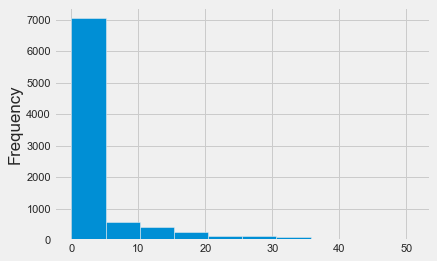

In [40]:
# Sort the 'trips_extended' df by the date index
trips_extended= trips_extended.set_index("Start Date").sort_index()

# Create a dataframe with hourly resampling the 'trips_extended' df
# Sum the number of departures and arrivals in each station and each hour
trips_extended_hourly= trips_extended.resample('H').sum()

# See the departures distibution of station 70
trips_extended_hourly["70d"].plot(kind="hist");

In [41]:
# Create stations_hourly df by taking just the stations column
stations_hourly=trips_extended_hourly[arrival_lst+departure_lst].reset_index(drop=True)
stations_hourly.head(2)

2a  3a  4a  5a  6a  7a  8a  9a  10a  11a  12a  13a  14a  16a  21a  22a  \
0   0   0   0   0   0   0   0   0    0    0    0    0    0    0    0    0   
1   0   0   0   0   0   0   0   0    0    0    0    0    0    0    0    0   

   85a  25a  86a  26a  27a  28a  29a  30a  31a  32a  33a  34a  35a  36a  37a  \
0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

   38a  41a  42a  45a  46a  47a  48a  87a  50a  51a  39a  54a  55a  56a  57a  \
0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

   58a  59a  60a  61a  62a  63a  64a  65a  66a  67a  68a  88a  70a  71a  90a  \
0    0    0    0    0    0    0    0    0    3    0    0    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

   73a  74a  75a  76a  77a  80a  82a  83a  84a  2d  3d  4d  5d  6d  7d  8d  \
0    0    0    0    0    0    0    0    0    0   0   0   0   0   0   0   0   
1    0    0    0    0    0    0    0    0    0   0   0   0   0   0   0   0   

   9d  10d  11d  12d  13d  14d  16d  21d  22d  85d  25d  86d  26d  27d  28d  \
0   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

   29d  30d  31d  32d  33d  34d  35d  36d  37d  38d  41d  42d  45d  46d  47d  \
0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

   48d  87d  50d  51d  39d  54d  55d  56d  57d  58d  59d  60d  61d  62d  63d  \
0    0    0    0    0    0    0    0    0    3    0    0    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

   64d  65d  66d  67d  68d  88d  70d  71d  90d  73d  74d  75d  76d  77d  80d  \
0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

   82d  83d  84d  
0    0    0    0  
1    0    0    0

In [42]:
stations_hourly.shape

(8760, 140)

Now we have our targets dataset: `stations_hourly`

<a id='split'></a>
### Data split with `TimeSeriesSplit`

- Since our dataset is a timeseries we must respect to the temporal order of the data. Thus, we must use only the past data to predict the future data.

- In order to stict to this principle we will take the last %10 of the sorted dataset as a hold-out set and use sklearn **TimeSeriesSplit** object for cross-validation


- In TimeSeriesSplit unlike standard cross-validation methods, successive training sets are supersets of those that come before them
- Also we should not shuffle the data. Sklearn `cross_validation`  defaults to not to shuffle
![timeseries](/images/timeseries.jpg)

<a id='featurestargets'></a>
#### Features and targets datasets split

In [43]:
# Targets dataset:y
y= stations_hourly
# Features dataset:X
X= features_df

# Find the starting indice of the last 10 percent for hold-out datasets
idx= int(len(y)* 0.90)
# Create the features train dataset: X_train
X_train= X.iloc[:idx, :]
# Create the features test dataset: X_test
X_test= X.iloc[idx:, :]
# Create the targets train dataset: y_train
y_train= y.iloc[:idx, :]
# Create the targets test dataset: y_test
y_test= y.iloc[idx: ,:]

print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape, "y_test shape:", y_test.shape)

X_train shape: (7884, 71) X_test shape: (876, 71)
y_train shape: (7884, 140) y_test shape: (876, 140)


<a id='multitarget'></a>
### Multi-target models

- Now we have our train and test datasets so we can fit a model and make the predictions. Here we have two approaches:
    - 1) to build one model per station
    - 2) to predict all the stations together in one model
    
 
- One model per station approach is not able to take into account of the **similarities between stations**. 



- In Sklearn some algorithms like random forest, knn and linear regression natively support multi-target regression thus suitable for second approach

- The others process the multi-target-regression only with the [MultiOutputRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputRegressor.html) but this works as the first approach. 
- Here is the explanation from the Sklearn page: *"This strategy consists of fitting one regressor per target. This is a simple strategy for extending regressors that do not natively support multi-target regression. As MultiOutputRegressor fits one regressor per target it can not take advantage of correlations between targets.*


- Till finding a better solution we will work with the algorithms that natively support multi-target regression 

<a id='140stations'></a>
## Model with 140 stations

<a id='baseline1'></a>
#### First baseline for the model with 140 stations
- In this model a target corresponding to a features sample will be a point with the permutations of 140 dimensions(70 arrivals and 70 departures)

- Here the baseline will be the estimate of these permutations. 
- We will take the average of the these permutations i.e hourly arrivals and departures as a baseline for this model and try to beat it.

In [44]:
# Add the time index to stations_hourly df
stations_hourly.index= trips_extended_hourly.index
# Take the averages of the columns
averages= stations_hourly.mean()
# Convert the averages into array
baseline= averages.values
# Stack vertically the baseline to match the y_test shape
baseline= np.tile(averages,(y_test.shape[0], 1))
# Check the shape of baseline
#print("baseline shape:", baseline.shape)

# Baseline errors are the mean of the differences between y_test and the baseline predictions
baseline_error= round (mean_squared_error(y_test.values, baseline)**0.5, 2)
print('Average baseline error: ', baseline_error)

Average baseline error:  1.7


The baseline estimates 1.7 arrivals or departures per hour.

### Training the first model

- Time to build our first model, using random forest implementation from Sklearn.

- We will use the first 90% of the data for training (the training data set is sorted by time), and the remaining 10% for testing.

- Let's write a simple function that returns the performance of the model and then train our first regressor.

<a id='valfunc'></a>
### `get_val_score_rf` function
- Since we need to calculate model performance during training with tuned parameters it would be better to define a function in order to reuse

In [45]:
def get_val_score_rf(X_tr, y_tr, dct):
    '''
    takes X_train, y_train and a dictionary containing hyperparameter inputs for random forest -> 
    returns the cross validation and X_train scores of the model. Both are calculated as 
    root mean squared errors 
    '''
    # Instantiate a RandomForestRegressor object by unpacking the parameters dictionary
    forest = RandomForestRegressor(**dct)
    # Instantiate TimeSeriesSplit object with 5 splits
    split=TimeSeriesSplit(n_splits=5)
    # Calculate the performance with cross-validation
    score = cross_val_score(forest, X_tr, y_tr, cv=split, scoring='neg_mean_squared_error', n_jobs=-1)
    # Take the sqrt all the splits 
    score= np.sqrt(abs(score))
    print("Cross-validation scores:", score,"\n","Cross-validation mean:", f'{np.mean(score):.2f}')
    # fit the model
    forest.fit(X_train, y_train)
    # Predict the train set to see if there is over fitting
    pred_train=forest.predict(X_train)
    print(f'RMSE Train:{np.sqrt(mean_squared_error(y_train, pred_train)):.2f}')  

<a id='firstscore'></a>
#### First scores of the model
- Let's get the first scores of our model with initial hyperparameter settings. We will do the feature selection and hyperparameter tuning afterwards.

- Let's start with some parameter tips from Sklearn's site to see the first performance.

In [46]:
# Create the params dictionary with basic hyperparameters, include the random_state
initial_params={'n_estimators':100,
        'max_depth':3,
        'min_samples_leaf':2,
        'random_state':37}

# Call the get_val_score_rf on the params dictionary
get_val_score_rf(X_train, y_train, initial_params)

Cross-validation scores: [1.21253239 1.17777628 1.23724672 1.23315127 1.27263581] 
 Cross-validation mean: 1.23
RMSE Train:1.23


- Model looks little bit underfitting because  $rmseTRAIN \approx rmseCV$
- Additional data would be great 
- We can try 
    - feature selection
    - increase the number of estimators, max_depth or decrease min_samples_leaf and look for better combination with other hyperparameters also.
    
- We will use this scores as **baseline2** and continue to improve our model with feature selection

# Feature selection

### Feature importance
- Even though we are using an ensemble method still random forest is dependent on decision trees and decision trees tend to overfit on data with a large number of features

- We can try omitting the features without prediction power in order to potentially increase the performance of our model and make it computationaly efficient.

- Let's check the feature importances by using two approach. 
- We can get the feature importances from Sklearn RandomForestRegressor however there are other methods also. 
- [Here there is an interesting article](https://explained.ai/rf-importance/index.html) about the biasedness of the Sklearn Random Forest future importance method. 

- For this work we will try both

<a id='featureimportance2'></a>
#### Feature importance by `sklearn RandomForestRegressor`
For regression trees the future importance is measured by how much each feature reduce the variance when they split the data

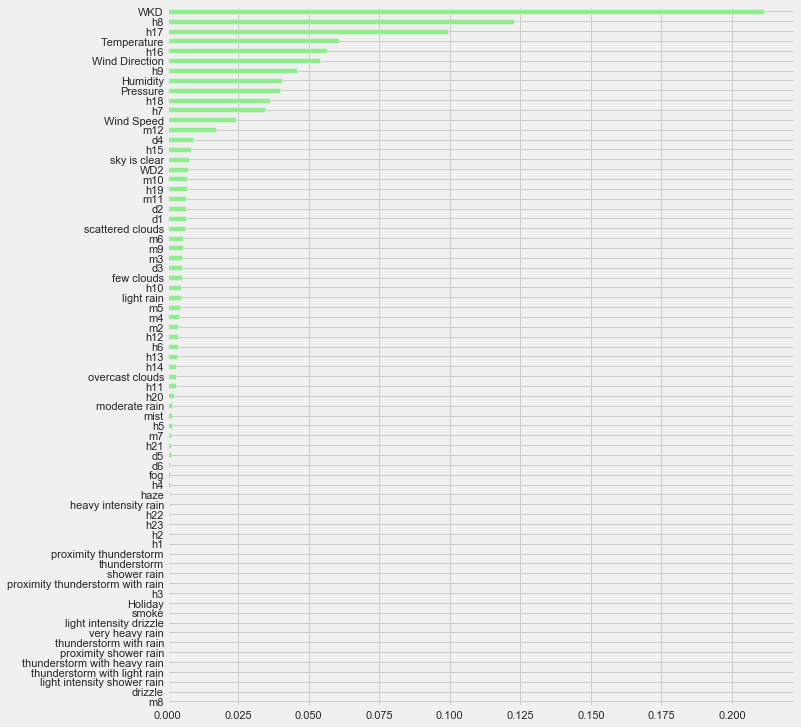

In [47]:
rf1 = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf1.fit(X_train, y_train)
# Train the regressor
rf1.predict(X_test)

# Create a pandas Series of features importances: importances
# containing the feature names as index and their importances as values
importances_rf = pd.Series(data=rf1.feature_importances_ , index= X_train.columns)

# Get the sorted importance values: importance_sorted
importance_sorted=importances_rf.sort_values()

# Plot the sorted importance values by using horizontal bars
importance_sorted.plot(kind="barh", color='lightgreen', figsize=(10, 12));

#### Cumulative importances
- We can get the cumulative importances from the sorted importances and fixed the level that we want to cut off.
- Below the 99% level is drawn for the Sklearn importance ranking

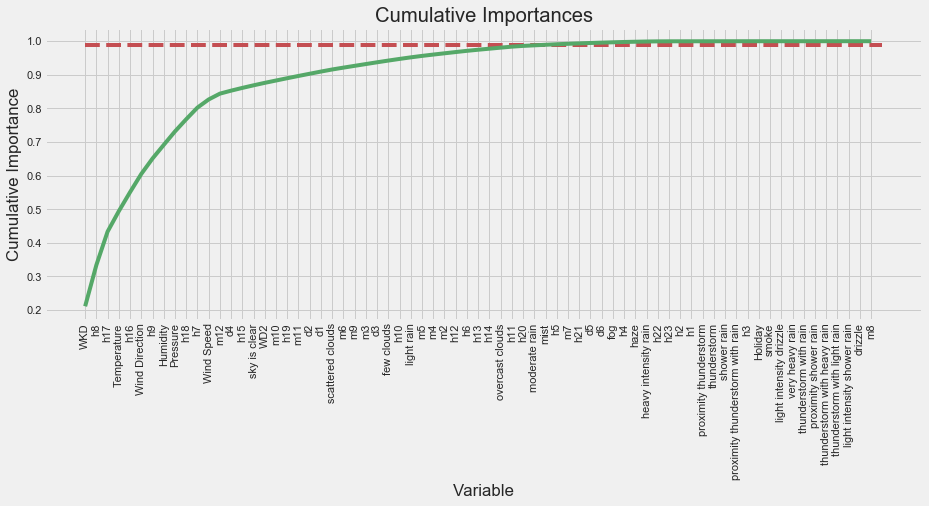

In [48]:
# Sort the importances in descending order
importance_desc=importances_rf.sort_values(ascending=False)
sorted_features=importance_desc.index

# Cumulate the importances
cumulative_importances = np.cumsum(importance_desc)

# list of x locations for plotting
x_values = list(range(len(importance_desc)))

plt.figure(figsize=(14,5))
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 99% of importance retained
plt.hlines(y = 0.99, xmin=0, xmax=len(importance_desc), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

Now we can find number of features for cumulative importance of 99%

In [49]:
# Add 1 because Python is zero-indexed
print('Number of features for 99.5% importance:', np.where(cumulative_importances > 0.995)[0][0] + 1)

# Extract the names of the most important features
important_features = [feature for feature in importance_desc[0:48].index]

# Create training and testing sets with only the important features
X_train_red_sk = X_train[important_features] # red_sk stands for reduced sklearn
X_test_red_sk = X_test[important_features]

# Sanity check
print('Important train features shape:', X_train_red_sk.shape)
print('Important test features shape:', X_test_red_sk.shape)

Number of features for 99.5% importance: 47
Important train features shape: (7884, 48)
Important test features shape: (876, 48)


In [51]:
# Check the scores of the X_train_red_sk to compare with the first feature df X_train
get_val_score_rf(X_train_red_sk, y_train, initial_params)

Cross-validation scores: [1.21231799 1.17721283 1.23724747 1.23315189 1.27263622] 
 Cross-validation mean: 1.23
RMSE Train:1.23


- After dropping 26 columns from the features dataset we get the same CV mean and RMSE train. It is better to continue with reduced dataset

<a id='featureimportance'></a>
#### Feature importance by ` rfpimp`

In [ ]:
# Instantiate a random forest object
rf_perm = RandomForestRegressor(n_estimators=100, n_jobs=-1)
# fit the model
rf_perm.fit(X_train, y_train)
# Apply the permutation function
imp = importances(rf_perm, X_test, y_test)
# plot the future importances
viz = plot_importances(imp)
viz.view()

- The results are quite different from each other however in both case as expected the **night hours** are not predictive. 
- In our chart analysis we have seen the bike usage was almost zero between 23h-04h.
- Binary features related with rain are not predictive in both cases, probably the number of the cases are not enough to learn and also it is corelated with humidity
- We can test both of the performances of the two reduced dataset regarding the results of two ranking of importances

#### Most important futures with `rfpimp` 

In [ ]:
# Cumulate the importances
cumulative_imp = np.cumsum(imp.values)
# Add 1 because Python is zero-indexed
print('Number of features for 99.9% importance:', np.where(cumulative_imp > 0.999)[0][0] + 1)

# Extract the names of the most important features
important_perm = [feature for feature in imp[0:20].index]
# Create training and testing sets with only the important features
X_train_perm = X_train[important_perm] # red_sk stands for reduced sklearn
X_test_perm= X_test[important_perm]

# Sanity check
print('Important train features shape:', X_train_perm.shape)
print('Important test features shape:', X_test_perm.shape)

In [ ]:
# Check the scores of the X_train_perm to compare with 
# the first feature df(X_train) and the X_train_red_sk 
get_val_score_rf(X_train_perm, y_train, params)

We get the same score just with 20 columns using `rfpimp`.

<a id='tuning'></a>
## Hyperparameters tuning
### Randomized Search CV
- Let's run a randomized search for hyperparameter tuning.  
- We can define a grid of hyperparameter ranges, and randomly sample from the grid by performing cross-validation on each combination of values using Sklearn's `RandomizedSearchCV` object

- Even though RandomizedSearchCV is not an exhaustive search like GridSearch it can be computationally heavy depending on our choise of number of iteration and cross-validation and ranges of hyperparameters. 


- Both in Randomized and Grid Search we should use
    - `scoring='neg_mean_absolute_error'` argument as our loss function is RMSE and
    - `TimeSeriesSplit` as CV splits as we work with timeseries data
    
    
- Here we will do a simple search with 10 iteration and 2 cross validation and will not tune all the hyperparameters.

In [ ]:
# Create the base model to tune
forest_tune = RandomForestRegressor()
# print and see all the parameters of RandomForestRegressor
pprint(forest_tune.get_params())

- As we see there are quite a lot parameters to tune.
- We will focus on the most important ones: `'n_estimators', 'max_depth'` and `'min_samples_leaf'`. 
- However we will create the full grid to make it ready for furher searches. We can play with the ranges depending on our time. 
- Please uncomment the parameters in the dictionary to run a wider search.

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop =1000, num = 3)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 50, num = 2)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               #'max_features': max_features,
               #'min_samples_split': min_samples_split,
               #'bootstrap': bootstrap
               'min_samples_leaf': min_samples_leaf}

pprint(random_grid)

Since it is not efficient doing random search with the personal laptop at the moment we will try the random search on Google Colab with these parameters.

In [ ]:
# Create the splits for timeseries data 
split=TimeSeriesSplit(n_splits=2)
# Instantiate a Random Search object with parameters: n_iter = 10, cv = 2, 
forest_random = RandomizedSearchCV(estimator = forest_tune, 
                                   param_distributions = random_grid, 
                                   n_iter = 10, 
                                   cv = split,
                                   scoring='neg_mean_absolute_error',
                                   verbose=3, 
                                   random_state=37, 
                                   n_jobs = -1)

# Fit the random search model on reduced X_train_red_sk
#forest_random.fit(X_train_red_sk, y_train) #(pls uncomment to execute)

First results of the simple randomized search from Colab:
![params1](/images/params1.jpg)

#### Evaluate random search results

To find out if random search produced better model parameters than the previous one with `initial_params` we will run with new parameters and compare the results

In [ ]:
# Create the best params dictionary
best_params_random={'n_estimators':100,
                    'max_depth':50,
                    'min_samples_leaf':4,
                    'random_state':37}
# Check the scores of the X_train_red_sk
get_val_score_rf(X_train_red_sk, y_train, best_params_random)

#### Compare the scores before and after search

- Our first random forest model have the scores:
    - Cross-validation mean: 1.23
    - RMSE Train:1.23

- After applying the parameters of randomized search the scores becomes:
    - Cross-validation mean: 0.97
    - RMSE Train:0.74

The scores are both better and also this time it looks like it does not ovetfit

<a id='grid'></a>
### Grid Search CV

- Random search allowed us to narrow down the range for each hyperparameter. 
- Now we can specify more the combination of settings with GridSearchCV

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {'max_depth':[50, 60],
              'min_samples_leaf':[4, 5],
              'n_estimators':[100, 150]}
# Instantiate a RandomForestRegressor object
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, 
                           param_grid = param_grid, 
                           cv = split, 
                           scoring='neg_mean_absolute_error',
                           n_jobs = -1, 
                           verbose = 2)
pprint(param_grid)

In [ ]:
# (pls uncomment to execute)
# Fit the grid search to the data 
#grid_search.fit(X_train_red_sk, y_train)
#grid_search.best_params_

First results of the simple grid search from Colab:
![params2](/images/params2.jpg)

All the parameters augmented little bit.
#### Evaluate the GridSearch results

In [ ]:
# Create the best params dictionary
best_params_grid={'n_estimators':150,
                  'max_depth':60,
                  'min_samples_leaf':5,
                  'random_state':37}
# Check the scores 
get_val_score_rf(X_train_red_sk, y_train, best_params_grid)

- Cross-validation mean score did not change. (Only changed in the 3rd decimal probably). 
- Train score increased by 0.03 because of maximum depth difference. 
- Even though there is chance to improve results by tweaking the ranges. 
- For now we can stop our hypermeter tuning here. We will continue to use the previous random search results.
- Again, we have focused only on 3 hyperparameters due to the computational and time constraints. 

<a id='holdout'></a>
### Hold-out set score
- Now we can see our final test prediction performance by creating our final model

In [ ]:
# Instantiate a RandomForestRegressor object with the best parameters of random search
model_rf=RandomForestRegressor(**best_params_random)
# Fit the model 
model_rf.fit(X_train_red_sk, y_train)
# Predict the train set
pred_final=model_rf.predict(X_test_red_sk)

print(f'RMSE Test(hold-out):{np.sqrt(mean_squared_error(y_test, pred_final)):.2f}')

- Our test score improved to **0.90** from 0.97 CV mean. 
- It is high probaly thanks to the higher amount of training data (we used all the 5 folds together for training)

#### Test with the reduced `X_train_perm`

In [ ]:
# Instantiate a RandomForestRegressor object with the best parameters of random search
model_rf=RandomForestRegressor(**best_params_random)
# Fit the model 
model_rf.fit(X_train_perm, y_train)
# Predict the train set
pred_final=model_rf.predict(X_test_perm)

print(f'RMSE Test(hold-out):{np.sqrt(mean_squared_error(y_test, pred_final)):.2f}')

- We get the same test result by using the features dataset reduced by the `rfpimp`
- Since `X_train_perm` has less columns (20), it looks a better idea to use this dataset for model training and testing.

### Reminder: 
- So far the model we created predicts the number of arrivals and departures not their differences (net bike stock change)
- Our baselines were also about how close we are to the number of arrivals and departures not the net change.
- To get the net change predictions we need to convert the predictions of the model.

In [ ]:
# Save the model for future use 
filename = 'model_rf.model'
joblib.dump(model_rf, filename)

In [ ]:
# Check if the model properly saved
model=joblib.load(filename)
pred_joblib=model.predict(X_test_perm)
print(f'RMSE Test(hold-out):{np.sqrt(mean_squared_error(y_test, pred_joblib)):.2f}')

- Our model by construction predicting the number of arrivals and departure seperately thus when we give it unseen data and it returns `[n_unseen_data, 2*stations]` matrix. 

- So we need to define a function which converts the predictions into net change (`n_departures - n_arrivals`)

In [ ]:
def net_change(model, df):
    '''
    Takes our model and dataframe to predict returns->
    a dataframe with the half number of columns of the predictons made by our model
    by taking the difference of the departures and arrival columns
    '''
    # Create a dataframe from predictions
    predictions_df = pd.DataFrame(model.predict(df))
    # Create list of column names
    columns_lst = list(predictions_df.columns)
    # Create a list to aggregate the differences of departures and arrivals
    difference_cols =[]
    # Iterate over the column names list till the half point
    for idx in range(len(columns_lst)//2):
        # Collect the column differences in the list
        difference_cols.append(predictions_df[idx+70]-predictions_df[idx])
    # At the end of the loop concat all the columns at once
    net_rate_df = pd.concat(difference_cols, axis=1)
    return net_rate_df

In [ ]:
# Call the net_change on our model with test data
net_change(model_rf, X_test_perm).head(2)

As seen above we converted the predictions of arrivals and departures to the differences with 70 columns

<a id='netrate'></a>
### Net rates dataframe
- Lets create the net rates dataframe by taking the differences of departures and arrivals for each hour
- In this option the shape will be `[n_hours, n_stations]`, in our case `[8760, 70]` 

In [ ]:
# Create an empty list to aggregate the net change in every row(hour)
columns_lst=[]

## Loop over stations_hourly df columns to find the net change (arrivals-departures)
for station in stations_hourly.columns:
    if station[-1]=="a":
        station_arr = station
        station_dep = station[:-1]+ "d"
        # Append the column difference in the list
        columns_lst.append((stations_hourly[station_arr]- stations_hourly[station_dep]))

# Create the change_df by concatenating the columns in the column_lst
net_df = pd.concat(columns_lst, axis=1) 
# Create the column names of the net_df
net_cols =[]
for station in stations_hourly.columns:
    if station[-1]=="a":
        net_cols.append(station[:-1]+ "c")
# Add the column names        
net_df.columns = net_cols       
net_df.head(2)

In [ ]:
net_df.shape

<a id='final'></a>
### RMSE of the `predicted net changes` and the `actual net changes`
Now we can make the final evaluation of our 140 stations approach by finding the RMSE of the prediction of net change and the actual net changes.

In [ ]:
# Get the predictions of the test 
predicted_net_change= net_change(model_rf, X_test_perm)
# Actual net changes
actual_net_change=y_test_net
# Get the Root Mean Squared Errors of differences
rmse_model_rf=round(mean_squared_error(y_test_net, predicted_net_change)**0.5, 2)
rmse_model_rf

Our model's performance decreased to 2.89 on prediction the net rate change

<a id='70stations'></a>
# Model with 70 stations
##  `Net Rate` targets approach

- Now we will try the **net rate** approach by directly taking the net bike stock change in an hour in a station as targets data

- Here we will repeat the same steps like we did before for the dataset with targets as arrivals and departures.

<a id='targetnet'></a>
#### Target datasets : `y_train_net`, `y_test_net`
- We only need to split the targets dataset (`net_df`)
- We can contunie to use the splitted `X_train` and `X_test` as features datasets

In [ ]:
# Targets dataset:y
y_net= net_df

# Find the starting indice of the last 10 percent for hold-out datasets
idx= int(len(y_net)* 0.90)

# Create the targets train dataset: y_train_net
y_train_net= y_net.iloc[:idx, :]
# Create the targets test dataset: y_test_net
y_test_net= y_net.iloc[idx: ,:]

# Check the shapes
print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)
print("y_train shape:", y_train_net.shape, "y_test shape:", y_test_net.shape)

<a id='baselinenet'></a>
#### First baseline method for net rate approach

In [ ]:
# Take the averages of the columns
averages= net_df.mean()
# Convert the averages into array
baseline= averages.values
# Stack vertically the baseline to match the y_test shape
baseline= np.tile(averages,(y_test_net.shape[0], 1))
# Check the shape of baseline
#print("baseline shape:", baseline.shape)
# Baseline errors are the mean of the differences between y_test and the baseline predictions
baseline_error= round (mean_squared_error(y_test_net.values, baseline)**0.5, 2)
print('Average baseline error: ', baseline_error)

- Quite interesting just taking the daily averages can estimates 1.72 bikes difference on the average

<a id='perform'></a>
#### First model performance with net rate targets
We will use the validation function `get_val_score_rf` that we defined in the previous part to evaluate the first performance of random forest algorithm with the parameters below.

In [ ]:
# Create the params dictionary with basic hyperparameters, include the random_state
params={'n_estimators':100,
        'max_depth':3,
        'min_samples_leaf':2,
        'random_state':37}

# Call the get_val_score_rf on X_train_net the params dictionary
get_val_score_rf(X_train, y_train_net, params)

- Even with these parameters net change model beats the first model (140 targets)
- Also these scores are better than the first baseline of this approach
- Score improved from 1.72 to 1.23

#### Feature importance  ` rfpimp`
Now we can continue with the features importance function 

In [ ]:
# Instantiate a random forest object
rf_perm = RandomForestRegressor(n_estimators=100, n_jobs=-1)
# fit the model
rf_perm.fit(X_train, y_train_net)
# Apply the permutation function
imp = importances(rf_perm, X_test, y_test_net)
# Cumulate the importances
cumulative_imp = np.cumsum(imp.values)
# Add 1 because Python is zero-indexed
print('Number of features for 99.9% importance:', np.where(cumulative_imp > 0.999)[0][0] + 1)

According to model importance funtion only 4 features are enough to get the 99.9% prediction power. 

In [ ]:
# Extract the names of the most important features. Let's keep 20 of them
important_net = [feature for feature in imp[0:20].index]
# Create training and testing sets with only the important features
X_train_red_net = X_train[important_perm] # red_sk stands for reduced sklearn
X_test_red_net= X_test[important_perm]

# Sanity check
print('Important train features shape:', X_train_red_net.shape)
print('Important test features shape:', X_test_red_net.shape)

#### Model performance with randomized search parameters
- We did a RandomizedSearchCV on Colab and get the parameters below. Let's get the cross validation scores on reduced features with tweaked parameters

In [ ]:
# Parameters from RandomizedSearchCV
params_random={'n_estimators':100,
               'max_depth':50,
               'min_samples_leaf':4,
               'random_state':37}

# Call the get_val_score_rf on X_train_net the params dictionary
get_val_score_rf(X_train_red_net, y_train_net, params_random)

-  Cross-validation mean improved from 1.29 to 1.19
- RMSE Train improved from 1.23 to 0.74 

#### Model performance with Grid Search parameters
- After narrowing down the range we ran a simple grid search on Colab to tweak the parameters.

In [ ]:
params_grid={'n_estimators':100,
             'max_depth':60,
             'min_samples_leaf':5,
             'random_state':37}

# Call the get_val_score_rf on X_train, y_train_net and the params dictionary
get_val_score_rf(X_train_red_net, y_train_net, params_grid)

- Cross validation score just improved 0.01 and RMSE train get worse 0.03 point. We can use the previous parameters.

<a id='final'></a>
#### Test on hold-out set
- Now we can see our final test prediction performance with net rate targets by creating our final model

In [ ]:
# Instantiate a RandomForestRegressor object with the best parameters of random search
model_net_final=RandomForestRegressor(**best_params_random)
# Fit the model 
model_net_final.fit(X_train_red_net, y_train_net)
# Predict the train set
pred_final_net=model_net_final.predict(X_test_red_net)

print(f'RMSE Test(hold-out):{np.sqrt(mean_squared_error(y_test_net, pred_final_net)):.2f}')

Our test score on final hold-out set is 1.16 and little better than last cross validation score

#### Save model for future use 

In [ ]:
filename = 'model_net.model'
joblib.dump(model_net_final, filename)

In [ ]:
# Check if the model properly saved
model=joblib.load(filename)

pred_joblib=model.predict(X_test_red_net)
print(f'RMSE Test(hold-out):{np.sqrt(mean_squared_error(y_test_net, pred_joblib)):.2f}')

## Performance analysis

#### Model with 140 columns targets
- The model with 140 targets columns performance on predicting the arrivals and departures: 
![results140](/images/results140.jpg)

#### Model with 70 columns targets
![results70](/images/results70.jpg)

- With this final evaluation we completed our steps for this takehome project.